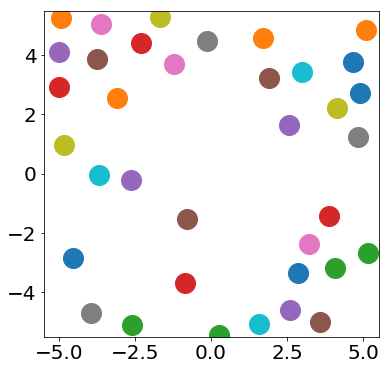

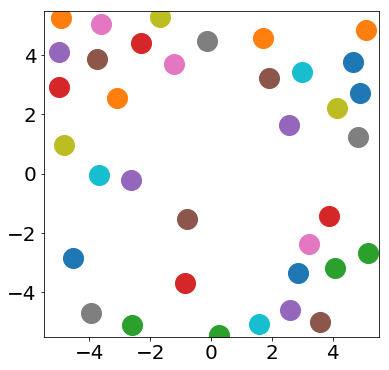

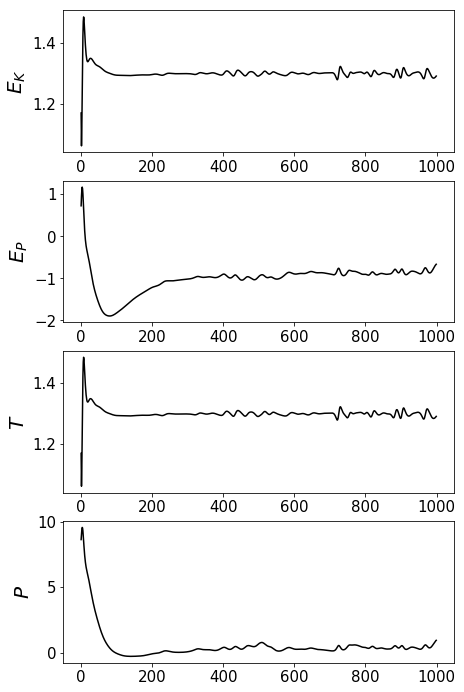

Temperature =  1.298693981099526 +/- 0.00573882447017813
Pressure =  0.2611734088795301 +/- 0.23519422555696007
Density =  0.2975206611570248


In [ ]:
#Import a plotting libraries and a maths library
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
%matplotlib inline

r = np.linspace(0.01,3.0,num=500) # Make a radius vector
epsilon = 1.0 # Energy minimum
sigma = 1.0 # Distance to zero crossing point
E_LJ = 4*epsilon*((sigma/r)**12-(sigma/r)**6) # Lennard-Jones potential

plt.figure(figsize=[6,6])
plt.plot(r,E_LJ,'r-',linewidth=1,label=r" $LJ\; pot$") # Red line is unshifted LJ

# The cutoff and shifting value
Rcutoff = 2.5
phicutoff = 4.0/(Rcutoff**12)-4.0/(Rcutoff**6) # Shifts the potential so at the cutoff the potential goes to zero

E_LJ_shift = E_LJ - phicutoff # Subtract the value of the potential at r=2.5*sigma

plt.plot(r[:415],E_LJ_shift[:415],'b-',linewidth=1,label="$LJ\; pot\; shifted$") # Blue line is shifted

#Plot formatting
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.title("$Lennard-Jones\; potential$",fontsize=20)
plt.xlim([0.0,3.0])
plt.ylim([-1.5,1.5])
plt.ylabel("$E_{LJ}/\epsilon$",fontsize=20)
plt.xlabel("$r/\sigma$",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.axhline(0, color='grey',linestyle='--',linewidth=2)
plt.axvline(1, color='grey',linestyle='--',linewidth=2)

# Defining system and initialising particle positions
DIM = 2 # Dimensions
N = 36

BoxSize = 11.0 # Vary between 7.0 and 25

volume  = BoxSize**DIM
density = N / volume
print("volume = ", volume, " density = ", density)

pos = np.zeros([N,DIM])
        
pos = np.genfromtxt('initial.dat') # Load positions from file
pos = pos[:,:DIM]/BoxSize

MassCentre = np.sum(pos,axis=0)/N

for i in range(DIM):
    pos[:,i] = pos[:,i]-MassCentre[i]


# Setting up the simulation
NSteps=5000 # Number of steps
deltat = 0.0032 # Time step in reduced time units
TRequested = 1.3 # #Reduced temperature
DumpFreq = 50 # Save the position to file every DumpFreq steps
epsilon = 1.0 # LJ parameter for the energy between particles

# Main MD loop
def main(pos, NSteps, deltat, TRequested, DumpFreq, epsilon, BoxSize, DIM):
    
    # Vectors to store parameter values at each step
    N = np.size(pos[:,1])
    ene_kin_aver = np.ones(NSteps)
    ene_pot_aver = np.ones(NSteps)
    temperature = np.ones(NSteps)
    virial = np.ones(NSteps)
    pressure = np.ones(NSteps)
    ene_pot = np.ones(N)

    vel = (np.random.randn(N,DIM)-0.5)
    acc = (np.random.randn(N,DIM)-0.5)

    # Open file which we will save the outputs to
    f = open('traj.xyz', 'w')
    
    all_positions = []  # List to store positions at each step

    for k in range(NSteps):
        
        # Refold positions according to periodic boundary conditions
        for i in range(DIM):
            period = np.where(pos[:,i] > 0.5)
            pos[period,i]=pos[period,i]-1.0
            period = np.where(pos[:,i] < -0.5)
            pos[period,i]=pos[period,i]+1.0

        # r(t+dt) modify positions according to velocity and acceleration
        pos = pos + deltat*vel + 0.5*(deltat**2.0)*acc # Step 1

        # Calculate temperature
        ene_kin_aver[k],temperature[k] = Calculate_Temperature(vel,BoxSize,DIM,N)

        # Rescale velocities and take half step
        chi = np.sqrt(TRequested/temperature[k])
        vel = chi*vel + 0.5*deltat*acc # v(t+dt/2) Step 2

        # Compute forces a(t+dt),ene_pot,virial
        acc, ene_pot_aver[k], virial[k] = Compute_Forces(pos,acc,ene_pot,epsilon,BoxSize,DIM,N) # Step 3

        # Complete the velocity step 
        vel = vel + 0.5*deltat*acc # v(t+dt/2) Step 4

        # Calculate temperature
        ene_kin_aver[k],temperature[k] = Calculate_Temperature(vel,BoxSize,DIM,N)

        # Calculate pressure
        pressure[k]= density*temperature[k] + virial[k]/volume
        
        
        # Print output to file every DumpFreq number of steps
        if(k%DumpFreq==0): # The % symbol is the modulus so if the Step is a whole multiple of DumpFreq then print the values

            f.write("%s\n" %(N)) # Write the number of particles to file
            all_positions.append(pos.copy())
            # Write all of the quantities at this step to the file
            f.write("Energy %s, Temperature %.5f\n" %(ene_kin_aver[k]+ene_pot_aver[k],temperature[k]))
            for n in range(N): # Write the positions to file
                f.write("X"+" ")
                for l in range(DIM):
                    f.write(str(pos[n][l]*BoxSize)+" ")
                f.write("\n")
            
            if(DIM==2):
                import matplotlib.pyplot as plt
                from IPython import display
                plt.cla()
                plt.xlim(-0.5*BoxSize,0.5*BoxSize)
                plt.ylim(-0.5*BoxSize,0.5*BoxSize)
                for i in range(N):
                    plt.plot(pos[i,0]*BoxSize,pos[i,1]*BoxSize,'o',markersize=20,)
                display.clear_output(wait=True)
                display.display(plt.gcf())
        #print(ene_kin_aver[k], ene_pot_aver[k], temperature[k], pressure[k]) 

    f.close() # Close the file
    
    return ene_kin_aver, ene_pot_aver, temperature, pressure, pos, all_positions
    

def Compute_Forces(pos,acc,ene_pot,epsilon,BoxSize,DIM,N):
    # Compute forces on positions using the Lennard-Jones potential
    # Uses double nested loop which is slow O(N^2) time unsuitable for large systems
    Sij = np.zeros(DIM) # Box scaled units
    Rij = np.zeros(DIM) # Real space units
    
    #Set all variables to zero
    ene_pot = ene_pot*0.0
    acc = acc*0.0
    virial=0.0
    
    # Loop over all pairs of particles
    for i in range(N-1):
        for j in range(i+1,N): #i+1 to N ensures we do not double count
            Sij = pos[i,:]-pos[j,:] # Distance in box scaled units
            for l in range(DIM): # Periodic interactions
                if (np.abs(Sij[l])>0.5):
                    Sij[l] = Sij[l] - np.copysign(1.0,Sij[l]) # If distance is greater than 0.5  (scaled units) then subtract 0.5 to find periodic interaction distance.
            
            Rij = BoxSize*Sij # Scale the box to the real units in this case reduced LJ units
            Rsqij = np.dot(Rij,Rij) # Calculate the square of the distance
            
            if(Rsqij < Rcutoff**2):
                # Calculate LJ potential inside cutoff
                # We calculate parts of the LJ potential at a time to improve the efficieny of the computation (most important for compiled code)
                rm2 = 1.0/Rsqij # 1/r^2
                rm6 = rm2**3.0 # 1/r^6
                rm12 = rm6**2.0 # 1/r^12
                phi = epsilon*(4.0*(rm12-rm6)-phicutoff) # 4[1/r^12 - 1/r^6] - phi(Rc) - we are using the shifted LJ potential
                # The following is dphi = -(1/r)(dV/dr)
                dphi = epsilon*24.0*rm2*(2.0*rm12-rm6) # 24[2/r^14 - 1/r^8]
                ene_pot[i] = ene_pot[i]+0.5*phi # Accumulate energy
                ene_pot[j] = ene_pot[j]+0.5*phi # Accumulate energy
                virial = virial - dphi*Rsqij # Virial is needed to calculate the pressure
                acc[i,:] = acc[i,:]+dphi*Sij # Accumulate forces
                acc[j,:] = acc[j,:]-dphi*Sij # (Fji=-Fij)
    return acc, np.sum(ene_pot)/N, -virial/DIM # return the acceleration vector, potential energy and virial coefficient

def Calculate_Temperature(vel,BoxSize,DIM,N):
    
    ene_kin = 0.0
    
    for i in range(N):
        real_vel = BoxSize*vel[i,:]
        ene_kin = ene_kin + 0.5*np.dot(real_vel,real_vel)
    
    ene_kin_aver = 1.0*ene_kin/N
    temperature = 2.0*ene_kin_aver/DIM
    
    return ene_kin_aver,temperature

# Perform the molecular dynamics simulation and return the results
ene_kin_aver, ene_pot_aver, temperature, pressure, pos, all_positions = main(pos, NSteps, deltat, TRequested, DumpFreq, epsilon, BoxSize, DIM)

# Plot all of the quantities
def plot():
    plt.figure(figsize=[7,12])
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15)
    plt.subplot(4, 1, 1)
    plt.plot(ene_kin_aver,'k-')
    plt.ylabel(r"$E_{K}$", fontsize=20)
    plt.subplot(4, 1, 2)
    plt.plot(ene_pot_aver,'k-')
    plt.ylabel(r"$E_{P}$", fontsize=20)
    plt.subplot(4, 1, 3)
    plt.plot(temperature,'k-')
    plt.ylabel(r"$T$", fontsize=20)
    plt.subplot(4, 1, 4)
    plt.plot(pressure,'k-')
    plt.ylabel(r"$P$", fontsize=20)
    plt.show()

# Add this new function to create the animation
def create_animation(positions, box_size):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-0.5*box_size, 0.5*box_size)
    ax.set_ylim(-0.5*box_size, 0.5*box_size)
    ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Particle Trajectories')

    particles, = ax.plot([], [], 'bo', ms=6)

    def init():
        particles.set_data([], [])
        return particles,

    def animate(frame):
        x = positions[frame][:, 0] * box_size
        y = positions[frame][:, 1] * box_size
        particles.set_data(x, y)
        return particles,

    anim = FuncAnimation(fig, animate, init_func=init, frames=len(positions),
                         interval=50, blit=True)
    
    return anim

# Print average temperature and pressure, excluding starting transient response
print("Temperature = ", np.average(temperature[100:]), "+/-", np.std(temperature[100:]))
print("Pressure = ", np.average(pressure[100:]), "+/-", np.std(pressure[100:]))
print("Density = ", density)

# Create and display the animation
anim = create_animation(all_positions, BoxSize)
plt.close(anim._fig)
HTML(anim.to_jshtml())

